### Organisation of Petroleum Exporting Country
#### The price of oil has a great domino effect on the cost of other products. In addition, most of the boats engine used petrol as a source of fuel.
Data source: https://data.nasdaq.com/data/OPEC-organization-of-the-petroleum-exporting-countries

## 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = '3WNekAyB_9LEanZFQK_Z'

In [3]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('OPEC/ORB')

In [4]:
data.head(5)

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [5]:
data.shape

(5085, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

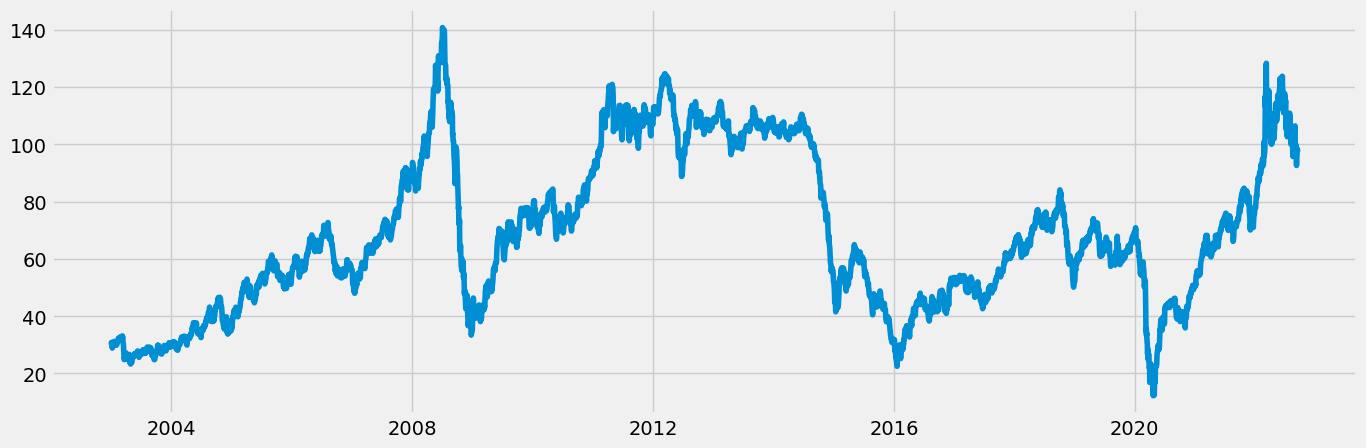

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

#### The data requires some smoothing has there are too many data points

## 2. Data Wrangling

## Smoothing using simple moving average to making the dataframe more applicable for forecasting


In [9]:
# Smooth Moving Average for the data (30 days)
data['SMA'] = data['Value'].rolling(30).mean()

In [10]:
data.dropna(inplace = True)

In [11]:
data.head()

,Value,SMA
Date,,
2003-02-12,31.30,30.474667
2003-02-13,31.91,30.536667
2003-02-14,32.33,30.586667
2003-02-17,31.90,30.626333
2003-02-18,31.85,30.697333


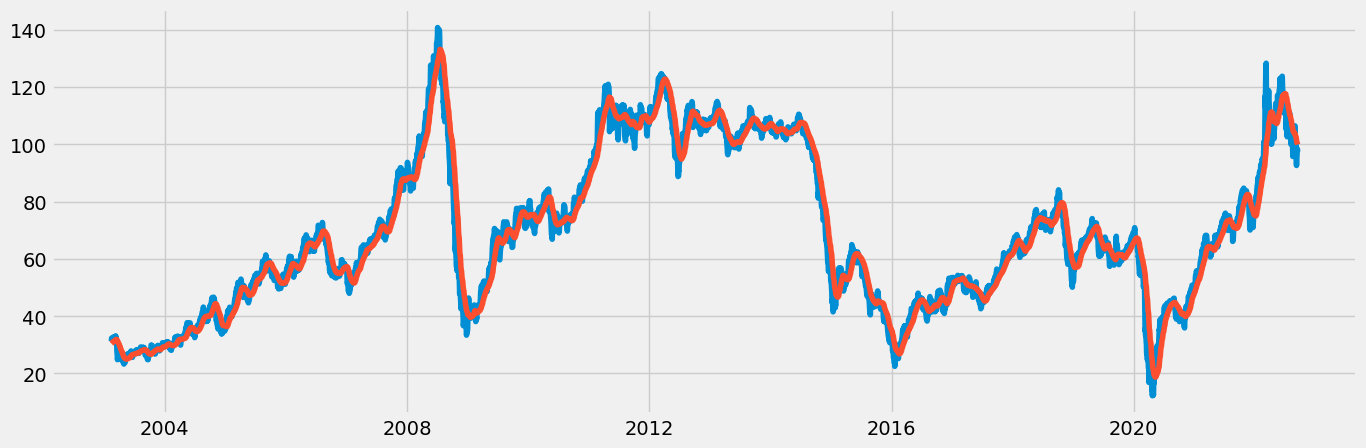

In [12]:
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

#### The smoothing curve would be used as this has less noise

## Subsetting, wrangling, and cleaning time-series data

In [13]:
# Reset index so that you can use the "Date" column as a filter
data = data.reset_index()

In [14]:
# Extract month from the 'Date' column in the dataframe
data['Month'] = pd.DatetimeIndex(data['Date']).month

In [15]:
# Extract year from the 'Date' column in the dataframe
data['Year'] = pd.DatetimeIndex(data['Date']).year

In [16]:
# Creating a new column with year and month combined
data['Date_new'] = pd.to_datetime(data.Year.astype(str) + '-' + data.Month.astype(str))

In [17]:
data.head() 

,Date,Value,SMA,Month,Year,Date_new
0,2003-02-12,31.30,30.474667,2,2003,2003-02-01
1,2003-02-13,31.91,30.536667,2,2003,2003-02-01
2,2003-02-14,32.33,30.586667,2,2003,2003-02-01
3,2003-02-17,31.90,30.626333,2,2003,2003-02-01
4,2003-02-18,31.85,30.697333,2,2003,2003-02-01


In [18]:
# Creating a new dataframe with median value grouped by 'Date_new'
data_group = data.groupby('Date_new').agg({'SMA': ['median']})

In [19]:
data_group.shape

(236, 1)

In [20]:
data_group.head(5)

,SMA
,median
Date_new,
2003-02-01,30.866000
2003-03-01,31.451667
2003-04-01,27.851000
2003-05-01,25.182333
2003-06-01,26.355667


#### The 'Date_new'column is already set as index

In [21]:
data_group.dtypes

SMA  median    float64
dtype: object

In [22]:
# Check for missing values (you shouldn't have any)

data_group.isnull().sum() 

SMA  median    0
dtype: int64

In [23]:
# Check for duplicates

dups = data_group.duplicated()
dups.sum()

0

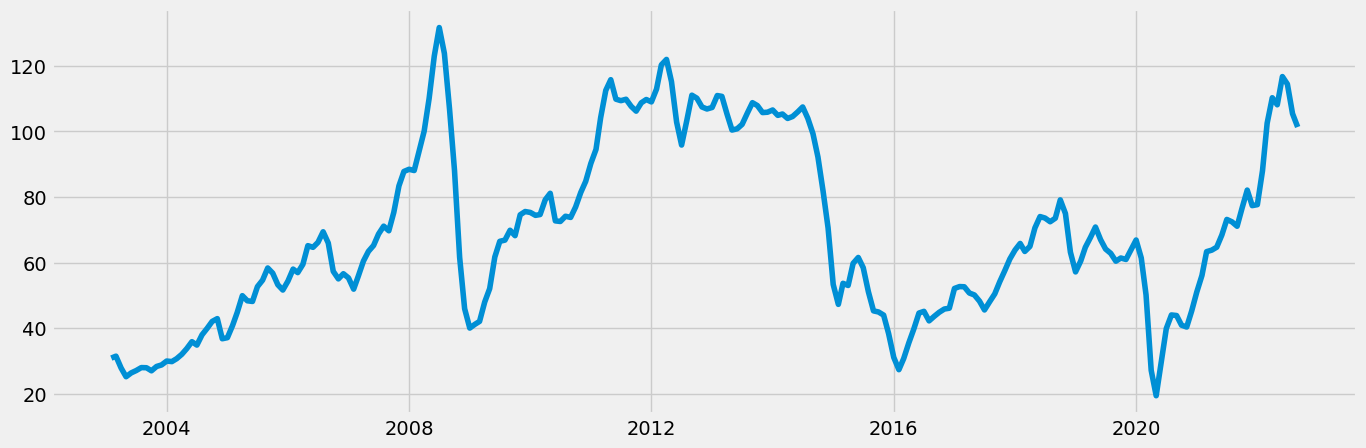

In [24]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_group)

In [25]:
data_group.columns

MultiIndex([('SMA', 'median')],
           )

## 3. Decomposing of the data for time-series analysis


In [26]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(x = data_group, model='additive')


In [27]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

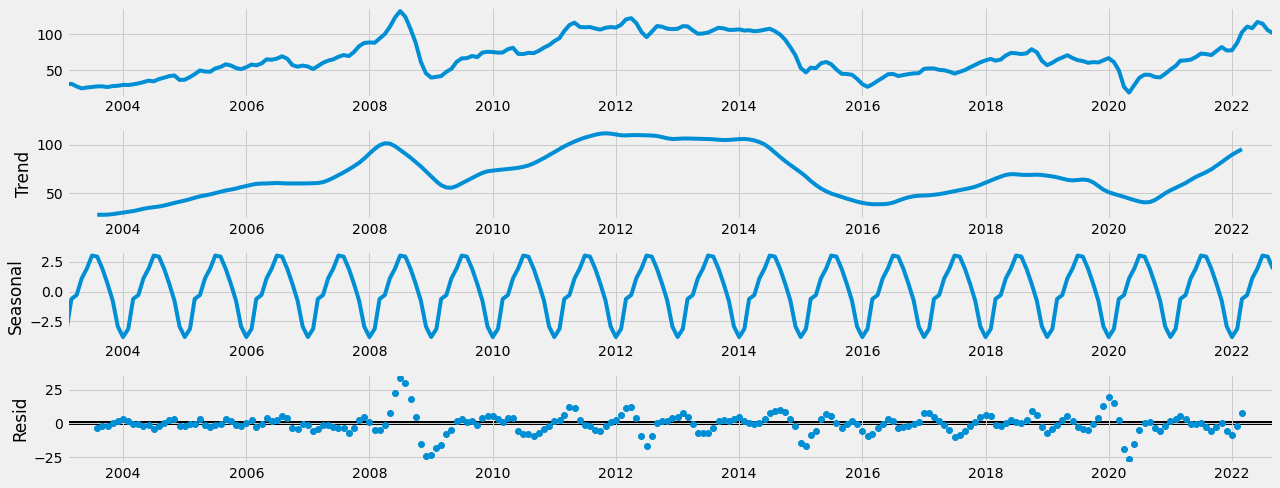

In [28]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The decomposition clearly shows the variation in the world oil median price from 2003 - 2022. The trend line chart appears allows the same because it does not have huge variation because smoothing has been pre applied on the data. 

#### Essentially, the plot shows seasonality due to a pattern repeating itself at the same time each year. However, the residual presents higher variations. Notable amongnst them is the post 2008 financialmeltdown  and the 2020 spring COVID-19 crises.


## 4. Testing for stationarity

### a. Dickey-Fuller Test
### It is vital data is stationary, otherwise, we will not have a reliable basis to build the forecasting on. The presence of a data trend implies the data is non-stationary. A Dickey-Fuller test will be conducted to check for stationarity.

In [29]:
# The adfuller() function will import from the model from statsmodels for the test; however, 
# running it will only return an array of numbers. 
# This is the resaon to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_group['SMA'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.469121
p-value                          0.123169
Number of Lags Used              2.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


#### Considering a significance level of 5%, the “Critical Value of 5% has a value of -2.874026. This is smaller than the test statistic, which is -2.469121, which means that the null hypothesis cannot be rejected. 

#### This also means that the data is non-stationary.

### b. Autocorrelation Test

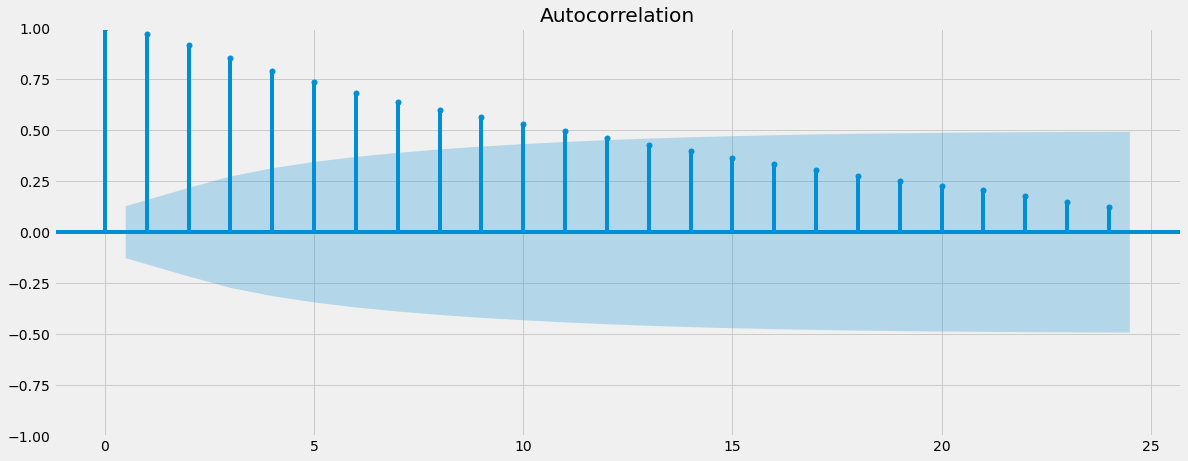

In [30]:
# Checking plot of autocorrelation

# Importing the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_group)
plt.show()

#### The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. Thus, it can be deduced that the data is non-stationary.

## 5. Stationarizing the Data

In [31]:
# Conducting the first round of differencing by subtracting the previous data point from the current data point
# The df.shift(1) function turns the observation to t-1, making the whole data t - (t -1)

data_diff = data_group - data_group.shift(1)

In [32]:
# Removing missing values as a result of differencing

data_diff.dropna(inplace = True)

In [33]:
# Checking values and headers

data_diff.head()

,SMA
,median
Date_new,
2003-03-01,0.585667
2003-04-01,-3.600667
2003-05-01,-2.668667
2003-06-01,1.173333
2003-07-01,0.711667


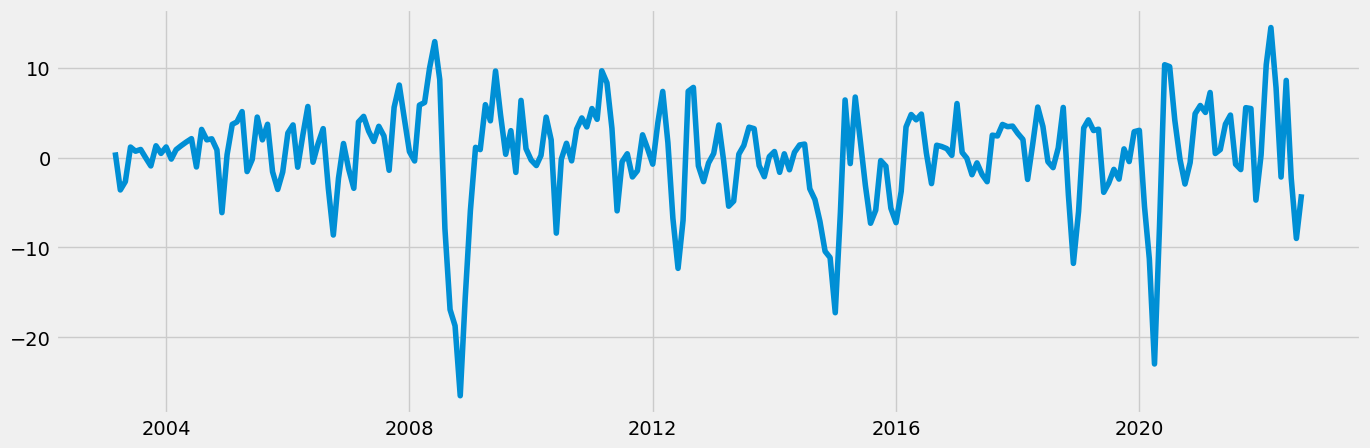

In [34]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [35]:
# Re-running the Dickey-Fuller Test to check for stationarity

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.531233e+00
p-value                        2.887101e-16
Number of Lags Used            1.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


#### The results show that the data is now stationary. The test statistic value (-9.531233) is smaller than the critical value (5%) of -2.874026 and the p-value is smaller than 0.05. Therefore, the test result is significant and the null hypothesis can be rejected.

#### The test statistics is also smaller than the critical values at 1 and 10%

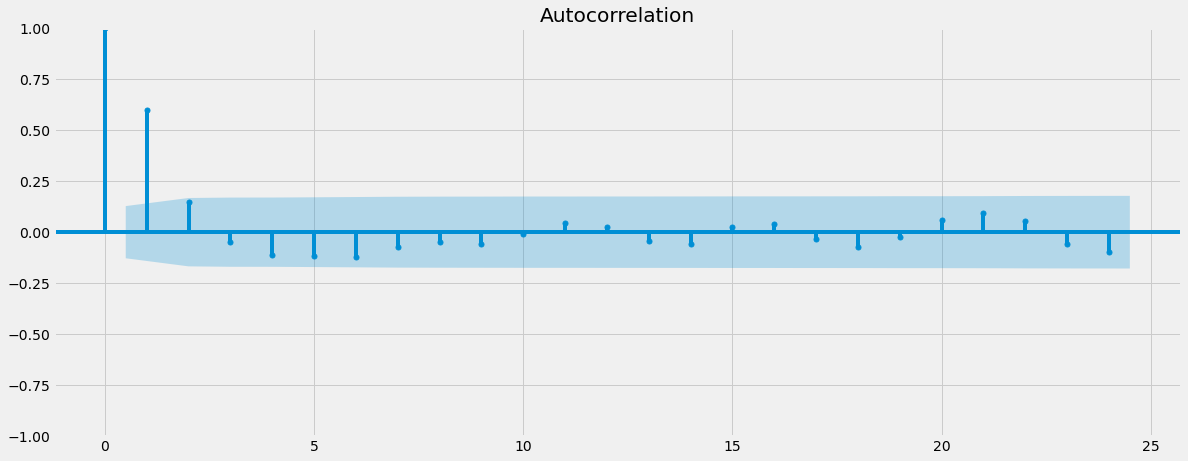

In [36]:
# Plotting the autocorrelation again

plot_acf(data_diff)
plt.show()

#### The autocorrelation plot has greatly improved. The stationary is strong due to all vertical lines staying below the confidence interval except one.